# Text classification using TfidVectorization and Multinomial Gaussian Naive Bayes
Using `spam.csv` dataset

# Import and inspect data

In [13]:
import numpy
import pandas
import warnings
warnings.filterwarnings('ignore')

In [16]:
data = pandas.read_excel("./sms-spam/spam.xlsx")
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Check null composition

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
v1            5572 non-null object
v2            5572 non-null object
Unnamed: 2    50 non-null object
Unnamed: 3    12 non-null object
Unnamed: 4    6 non-null object
dtypes: object(5)
memory usage: 217.7+ KB


### Drop columns

In [18]:
data.drop(['Unnamed: 2', 'Unnamed: 3','Unnamed: 4'], axis = 1, inplace = True)

In [19]:
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Add headers

In [20]:
data.columns = ["class", "message"]
data.head()

,class,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [27]:
data['class'].unique()

array(['ham', 'spam'], dtype=object)

In [28]:
def ham_or_spam(class_):
    if class_ == 'ham':
        return 1
    else:
        return 0

In [30]:
data['result'] = data['class'].apply(ham_or_spam)
data.head()

,class,message,result
0,ham,"Go until jurong point, crazy.. Available only ...",1
1,ham,Ok lar... Joking wif u oni...,1
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,0
3,ham,U dun say so early hor... U c already then say...,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",1


## Replace digits to avoid pipeline error 

In [36]:
import re 
def replace_digits(string):
    return re.sub('\d', '00.00', string)

In [38]:
data['message'] = data['message'].astype(str)
data['message_new'] = data['message'].apply(replace_digits)

# Build Model

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# Create feature matrix and target vector

In [40]:
X = numpy.array(data["message"])
y = numpy.array(data["result"])

# Train test split (20/80 split)

In [41]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, 
                                                y,
                                                test_size = 0.20,
                                                random_state = 0)

# Create pipeline 
Pipeline will include
- Count vectorizer
- Term frequency inverse document frequency transformer
- Grid Search CV

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV

In [43]:
text_clf = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

text_clf = text_clf.fit(Xtrain, ytrain)

In [44]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 
              'tfidf__use_idf': (True, False), 
              'clf__alpha': (.01, .005, .001, .0001, .00001, .1, .5, .05)}

# Fit the model using parameters found in `GridSearchCV`

In [45]:
grid_clf = GridSearchCV(text_clf, parameters, n_jobs = -1)
grid_clf = grid_clf.fit(Xtrain, ytrain)

In [46]:
grid_clf.best_params_

{'clf__alpha': 0.05, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

# Make predictions using new model against test data (`Xtest`)

In [47]:
y_prediction = text_clf.predict(Xtest)

# Validate accuracy against `ytest`

In [48]:
accuracy = accuracy_score(y_prediction, ytest)

In [49]:
print('{:.2%}'.format(accuracy))

96.59%


# Cross Validate Model
Check if model generalizes well. Perform 10 fold cross validation on model

In [50]:
from sklearn.model_selection import cross_val_score

In [51]:
scoring = "accuracy"
kfold = 10
results = cross_val_score(grid_clf, Xtrain, ytrain, cv= kfold, scoring = scoring)
print(results)

[0.99328859 0.98206278 0.98654709 0.99327354 0.98878924 0.98878924
 0.98651685 0.98426966 0.97977528 0.99550562]


In [52]:
import seaborn
import matplotlib.pyplot as plt
seaborn.set_style = "whitegrid"
seaborn.set(rc = {"figure.figsize":(14,8)},
           font_scale = 2)

# Generate confusion matrix
Check how model performed by visualizing true vs predicted labels

Text(0.5, 1.0, 'Confusion Matrix\n Predicted vs True counts')

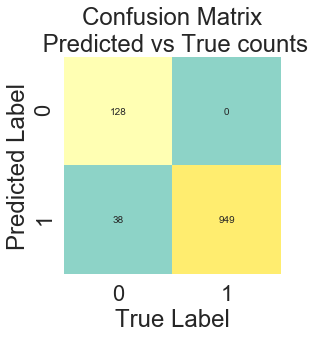

In [54]:
from sklearn.metrics import confusion_matrix


confusion_matrix = confusion_matrix(ytest, y_prediction)

seaborn.heatmap(confusion_matrix.T, 
               square  = True,
               annot = True,
               fmt = "d",
               cbar = False,
               cmap = "Set3")

plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.title("Confusion Matrix\n Predicted vs True counts")